# Nonlocal heat equation

In [1]:
# dependencies
import Pkg
Pkg.build("PyCall")
Pkg.add("ProgressMeter")
Pkg.add("PyPlot")
using PyPlot
using ProgressMeter

  Building Conda ─→ `~/.juliapro/JuliaPro_v1.1.0.1/packages/Conda/CpuvI/deps/build.log`
  Building PyCall → `~/.juliapro/JuliaPro_v1.1.0.1/packages/PyCall/ttONZ/deps/build.log`
  Updating registry at `~/.juliapro/JuliaPro_v1.1.0.1/registries/JuliaPro`
  Updating git-repo `https://pkg.juliacomputing.com//registry/JuliaPro`
 Resolving package versions...
  Updating `~/.juliapro/JuliaPro_v1.1.0.1/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.juliapro/JuliaPro_v1.1.0.1/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.juliapro/JuliaPro_v1.1.0.1/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.juliapro/JuliaPro_v1.1.0.1/environments/v1.1/Manifest.toml`
 [no changes]


## Definition of data
The initial datum is a box centered at $q_c$, width $q_w$ and height $q_h$
The weight $K$ is the sum of two boxes centered at $K_{c,j}$ width $K_{w,j}$ and height $K_{h,j}$, for $j=1,2$.

The boundary and nonlocal data are not yet implemented; effectively we work with homogeneous boundary and nonlocal conditions.

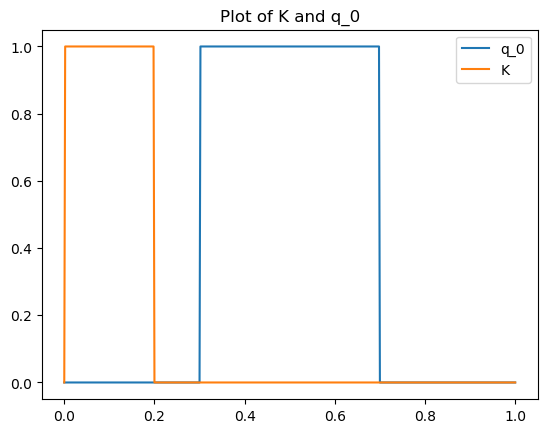

PyObject <matplotlib.legend.Legend object at 0x137da5cf8>

In [2]:
# K, q0 definition

(qc,qw,qh)=(0.5,0.4,1)
(Kc1,Kw1,Kh1)=(0.1,0.2,1)
(Kc2,Kw2,Kh2)=(0.75,0.5,0)
## g0, g1 not implemented


# check the definitions are valid
if qc-qw/2<0 || Kc1-Kw1/2<0 || Kc2-Kw2/2<0 || qc+qw/2>1 || Kc1+Kw1/2>1 || Kc2+Kw2/2>1
    print("Check all boxes used to define q and K are supported on [0,1]")
end

function boxfunc(x,c,w,h)
    if x>c-w/2 && x<c+w/2
        return h
    else
        return 0
    end
end

Xsteps = 501;
X = range(0,stop=1,length=Xsteps)

q0(x) = boxfunc(x,qc,qw,qh)
q0PLOT = [q0(x) for x in X];
plot(X,q0PLOT, label="q_0")

K(x) = boxfunc(x,Kc1,Kw1,Kh1) + boxfunc(x,Kc2,Kw2,Kh2)
KPLOT = [K(x) for x in X];
plot(X,KPLOT, label="K")

title("Plot of K and q_0")
legend()

## Definition of integrands
The function `EvalInt` evaluates the integral
$$
    \int_0^1 \int_y^1 F_{yz}(y,z) dz dy
$$
where $G$ is an antiderivative of $F_y(y,y)$, and $F_{yz}$ is supported on the rectangle
$$
    \{(y,z):y_{\mathrm{min}}<y<y_{\mathrm{max}} , z_{\mathrm{min}}<z<z_{\mathrm{max}}\}.
$$

We use `EvalInt` to express $\zeta^\pm$ efficiently.
Indeed, choosing $F_{yz}(y,z) = i\sin([z-y]\lambda) K(y) q_0(z)$, we see that
$$
    \zeta^-(\lambda;q_0) = \int_0^1 \int_y^1 F_{yz}(y,z) dz dy.
$$
If $K$ and $q_0$ are box functions then, everywhere on its support, $F_{yz}(y,z) = i\sin([z-y]\lambda)$ and its support is the cartesian product of the supports of $K$ and $q_0$.
Therefore, $\zeta^-(\lambda;q_0)$ is given by

``
EvalInt(F,G,[max support of K],[min support of K],[max support of q_0],[min support of q_0])
``

where
$$
    F(y,z) = \frac{i}{\lambda^2}\sin([z-y]\lambda), \qquad\qquad G(y) = -\frac{i}{\lambda} y.
$$

Similarly, choosing $F'_{yz}(y,z) = \cos([1-z]\lambda)e^{-i\lambda y} K(z) q_0(y)$ and $F_{yz}(y,z) = \cos([1-y]\lambda)e^{-i\lambda z} K(y) q_0(z)$, we see that
$$
    \zeta^+(\lambda;q_0) = \int_0^1 \int_y^1 F'_{yz}(y,z) dz dy + \int_0^1 \int_y^1 F_{yz}(y,z) dz dy,
$$
after a change of variables in the first integral.
If $K$ and $q_0$ are box functions then, everywhere on its support, $F'_{yz}(y,z) = \cos([1-z]\lambda)e^{-i\lambda y}$ and its support is the cartesian product of the supports of $q_0$ and $K$.
If $K$ and $q_0$ are box functions then, everywhere on its support, $F_{yz}(y,z) = \cos([1-y]\lambda)e^{-i\lambda z}$ and its support is the cartesian product of the supports of $K$ and $q_0$.
Therefore, $\zeta^+(\lambda;q_0)$ is given by

``
EvalInt(F',G',[max support of q_0],[min support of q_0],[max support of K],[min support of K])
+
EvalInt(F,G,[max support of K],[min support of K],[max support of q_0],[min support of q_0])
``

where
$$
    F'(y,z) = \frac{-i}{\lambda^2}\sin([1-z]\lambda) e^{-i\lambda y}, \qquad\qquad G'(y) = \frac{i}{2\lambda}\left( \frac{i}{2\lambda} e^{i\lambda(1-2y)} - y e^{-i\lambda} \right).
$$
and
$$
    F(y,z) = \frac{-i}{\lambda^2}\sin([1-y]\lambda) e^{-i\lambda z}, \qquad\qquad G(y) = \frac{i}{2\lambda}\left( \frac{i}{2\lambda} e^{i\lambda(1-2y)} + y e^{-i\lambda} \right).
$$

So far, the function $H$ is not implemented.
Until this is done, we can only have homogeneous boundary and nonlocal conditions.

In [3]:
function EvalInt(F,G,ymin,ymax,zmin,zmax)
    if zmax<=ymin
        #1 checked
        return 0
    elseif ymax<=zmin
        #2 checked
        return F(ymax,zmax) - F(ymin,zmax) - F(ymax,zmin) + F(ymin,zmin)
    elseif ymin<=zmin && zmin<=ymax && ymax<=zmax
        #3 checked
        return - F(ymin,zmax) - F(zmin,zmin) + F(ymin,zmin) + F(ymax,zmax) - G(ymax) + G(zmin)
    elseif ymin<=zmin && zmax<=ymax
        #4 checked
        return - F(ymin,zmax) - F(zmin,zmin) + F(ymin,zmin) + F(zmax,zmax) - G(zmax) + G(zmin)
    elseif zmin<=ymin && ymax<zmax
        #5 checked
        return F(ymax,zmax) - F(ymin,zmax) - G(ymax) + G(ymin)
    else # in this case zmin<=ymin<=zmax<=ymax
        #6 checked
        return F(zmax,zmax) - F(ymin,zmax) - G(zmax) + G(ymin)
    end
end;

In [18]:
# integrand definition

#Delta(la) = 3 * exp((8+2im)*la) + (-9 + 12im) * exp((4+7im)*la) + (2 + 1im) * exp((-7+4im)*la) + (-5) * exp((-6-6im)*la) + (6 - 7im) * exp((1-8im)*la) + (8 - 5im) * exp((6-4im)*la) + (3 - 9im) * exp((4+4im)*la) + 2 * exp((-2-4im)*la)

Delta(la) = 5*(exp(la))^0 + 6*(exp(pi*la))^1 + 7*(exp(pi*la))^2 + 8*(exp(pi*la))^3 + 9*(exp(pi*la))^4

q0hat(la) = 2*qh/la * exp(-im*la*qc) * sin(la*qw/2);

zetam(la) = qh * (
    Kh1*EvalInt((y,z) -> im/la^2*sin((z-y)*la), y -> -im*y/la,  Kc1-Kw1/2,Kc1+Kw1/2,qc-qw/2,qc+qw/2)
    +
    Kh2*EvalInt((y,z) -> im/la^2*sin((z-y)*la), y -> -im*y/la,  Kc2-Kw2/2,Kc2+Kw2/2,qc-qw/2,qc+qw/2)
    );

zetap(la) = qh * (
    Kh1*(
        EvalInt((y,z) -> -im/la^2*exp(-im*y*la)*sin((1-z)*la),
            y -> - y*im*exp(-im*la)/(2*la) - exp(im*la*(1-2*y))/(4*la^2),
            Kc1-Kw1/2,Kc1+Kw1/2,qc-qw/2,qc+qw/2)
        +
        EvalInt((z,y) -> -im/la^2*exp(-im*y*la)*sin((1-z)*la),
            y -> y*im*exp(-im*la)/(2*la) - exp(im*la*(1-2*y))/(4*la^2),
            qc-qw/2,qc+qw/2,Kc1-Kw1/2,Kc1+Kw1/2)
        )
    +
    Kh2*(
        EvalInt((y,z) -> -im/la^2*exp(-im*y*la)*sin((1-z)*la),
            y -> - y*im*exp(-im*la)/(2*la) - exp(im*la*(1-2*y))/(4*la^2),
            Kc1-Kw1/2,Kc1+Kw1/2,qc-qw/2,qc+qw/2)
        +
        EvalInt((z,y) -> -im/la^2*exp(-im*y*la)*sin((1-z)*la),
            y -> y*im*exp(-im*la)/(2*la) - exp(im*la*(1-2*y))/(4*la^2),
            qc-qw/2,qc+qw/2,Kc1-Kw1/2,Kc1+Kw1/2)
        )
    );

H(la) = 0; ###NOT IMPLEMENTED

intR(la,x,t) = exp(im*la*x-la^2*t)*q0hat(la);
intp(la,x,t) = exp(im*la*x-la^2*t)*( zetap(la) + H(la) ) / Delta(la);
intm(la,x,t) = exp(im*la*x-la^2*t)*( exp(-im*la)*zetam(la) + H(la) ) / Delta(la);

## Zeros of $\Delta$
The zeros of $\Delta$ are displayed as points where the hue changes most rapidly in the figure below.

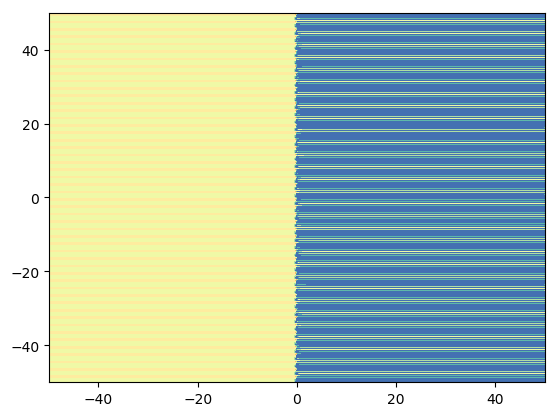

PyObject <matplotlib.contour.QuadContourSet object at 0x13bc95a90>

In [19]:
# plot showing zeros of Delta
x = range(-50,stop=50,length=1000); y = range(-50,stop=50,length=1000);
zarg = [sin(angle(Delta(xx+im*yy))) for yy in y, xx in x];
contourf(x, y, zarg, cmap=get_cmap("Spectral"))

## Plots of the solution
This code has not been optimised to allow for large values of myinfty.
Indeed, both the numerator and denominator of $\zeta^\pm(\lambda)/\Delta(\lambda)$ grow very large with large $\lambda$ on appropriate contours, exceeding floating point maximum if `myinfty>1000`.

Similarly, for $t>0.2$, errors in the highly oscillatory integrals damage accuracy.

In [6]:
# parameters of evaluation

myinfty=1000.0; # infinite contour integrals evaluated only to this far from 0
R=5; # semi-width of horizontal strip containing all zeros of Delta. This could be calculated using lemma 2.1, or an appropriate value could be chosen using the above plot of the zeros of Delta.
R0=0.1; # the real contour is deformed this far away from 0
tol=0.0001; # absolute tolerance of integral evaluation

In [7]:
# define the contoursc
cntrR = (-myinfty,-R0,im*R0,R0,myinfty);
cntrp = (myinfty*(im-1)/sqrt(2),R*(im-1),R*(im+1),myinfty*(im+1)/sqrt(2));
cntrm = (myinfty*(-im+1)/sqrt(2),R*(-im+1),R*(-im-1),myinfty*(-im-1)/sqrt(2));

# the following redefinitions of the contours are valid iff H=0, ie iff g_0=g_1=0
cntrp = (myinfty*(im/2-1)/sqrt(2),R*(im/2-1),R*(im/2+1),myinfty*(im/2+1)/sqrt(2));
cntrm = (myinfty*(-im/2+1)/sqrt(2),R*(-im/2+1),R*(-im/2-1),myinfty*(-im/2-1)/sqrt(2));

# definition of q(x,t) as a numerical integral
q(x,t) = (
    quadgk(la -> intR(la,x,t), cntrR[1],cntrR[2],cntrR[3],cntrR[4],cntrR[5]; abstol=tol)[1]
    -
    quadgk(la -> intp(la,x,t), cntrp[1],cntrp[2],cntrp[3],cntrp[4]; abstol=tol)[1]
    -
    quadgk(la -> intm(la,x,t), cntrm[1],cntrm[2],cntrm[3],cntrm[4]; abstol=tol)[1]
    ) / (2*pi);

Computing... 59%  ETA: 0:00:07

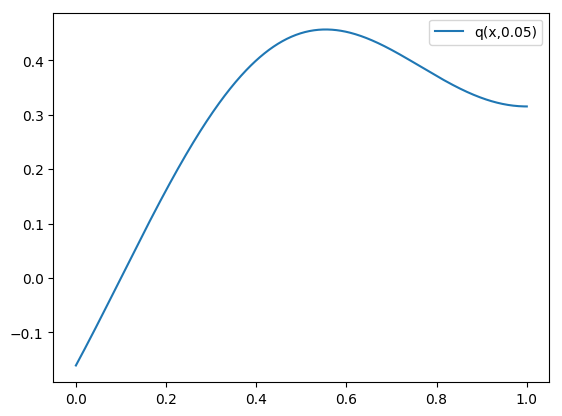

Computing...100% Time: 0:00:10


In [8]:
# evaluate and plot
T = 0.05;
Xsteps = 501;
X = linspace(0,1.00,Xsteps);

Q = ProgressMeter.@showprogress 1 "Computing..." [q(x,T) for x in X];
# Q = [q(x,T) for x in X];
realQ = real(Q);

plot(X,realQ, label="q(x,0.05)")
#title("Contribution from integrals up to infty = "*string(myinfty)*".")
legend()

## 3d surface plots

In [9]:
# 3d surface plot

Tsteps = 51
T = linspace(0.00001,0.2,Tsteps);
Xsteps = 101;
X = linspace(0.0,1.0,Xsteps);

# Q = ProgressMeter.@showprogress 1 "Computing..." [q(x,t) for x in X for t in T];



Q = ProgressMeter.@showprogress 1 "Computing..." [q(x,t) for t in T, x in X];
realQ = real(Q);

Computing...100% Time: 0:00:18


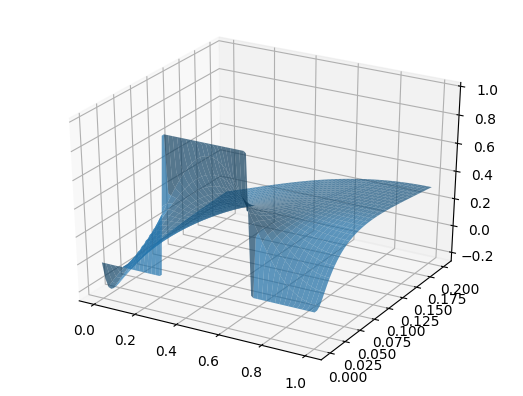

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f37bf6c2c90>

In [10]:
#plot_surface(X, T, realQ, α=0.8)
plot_surface(X, T, realQ, rstride=2, cstride=2,
    alpha=0.7, linewidth=0.25, label="q(x,t)")
#title("Contribution from integrals up to infty = "*string(myinfty)*".")
#legend()